Fake News Detection

In [1]:
import os
import pyspark
conf = pyspark.SparkConf()
# conf.set('spark.ui.proxyBase'
# , '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
conf.set('spark.sql.repl.eagerEval.enabled', True)
conf.set('spark.driver.memory','4g')
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.SQLContext.getOrCreate(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/21 14:42:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/21 14:42:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


/opt/conda/envs/bigdata-fall22/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [2]:
import pandas as pd
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType

schema= StructType(
      [StructField('title',StringType(),True),
      StructField('text',StringType(),True),
      StructField('subject',StringType(),True),
      StructField('date',StringType(),True)])

df0 = pd.read_csv('Fake.csv')
df1 = pd.read_csv('True.csv')
df_fake = spark.createDataFrame(df0,schema=schema)
df_true = spark.createDataFrame(df1,schema=schema)

In [3]:
# Display fake news

df_fake.show()

22/12/21 14:37:06 WARN TaskSetManager: Stage 0 contains a task of very large size (30118 KiB). The maximum recommended task size is 1000 KiB.


22/12/21 14:37:12 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker


+--------------------+--------------------+-------+-----------------+
|               title|                text|subject|             date|
+--------------------+--------------------+-------+-----------------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|
| Racist Alabama C...|The number of cas...|   News|December 25, 2017|
| Fresh Off The Go...|Donald Trump spen...|   News|December 23, 2017|
| Trump Said Some ...|In the wake of ye...|   News|December 23, 2017|
| Former CIA Direc...|Many people have ...|   News|December 22, 2017|
| WATCH: Brand-New...|Just when you mig...|   News|December 21, 2017|
| Papa John’s Foun...|A centerpiece of ...|   News|December 21, 2017|
| WATCH: Paul Ryan..

In [4]:
# Display fake news

df_true.show()

22/12/21 14:15:06 WARN TaskSetManager: Stage 1 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


22/12/21 14:15:10 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1 (TID 1): Attempting to kill Python Worker
+--------------------+--------------------+------------+------------------+
|               title|                text|     subject|              date|
+--------------------+--------------------+------------+------------------+
|As U.S. budget fi...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
|U.S. military to ...|WASHINGTON (Reute...|politicsNews|December 29, 2017 |
|Senior U.S. Repub...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
|FBI Russia probe ...|WASHINGTON (Reute...|politicsNews|December 30, 2017 |
|Trump wants Posta...|SEATTLE/WASHINGTO...|politicsNews|December 29, 2017 |
|White House, Cong...|WEST PALM BEACH, ...|politicsNews|December 29, 2017 |
|Trump says Russia...|WEST PALM BEACH, ...|politicsNews|December 29, 2017 |
|Factbox: Trump on...|The following sta...|politicsNews|December 29, 2017 |
|Trump on Twitter ...|The foll

In [3]:
# add a label to the data for fake news as 0 and true news as 1 and shuffle using rand
from pyspark.sql.functions import lit, rand

df= df_true.withColumn('flag', lit(1)).union(df_fake.withColumn('flag', lit(0))).orderBy(rand())

In [5]:
df.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: integer (nullable = false)



In [7]:
df.show()

22/12/21 14:15:19 WARN TaskSetManager: Stage 2 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+---------------+------------------+----+
|               title|                text|        subject|              date|flag|
+--------------------+--------------------+---------------+------------------+----+
| WATCH: Hilarious...|During a private ...|           News|     June 15, 2017|   0|
|Trump's missing d...|NEW YORK (Reuters...|   politicsNews| October 13, 2016 |   1|
|Divided on Trump,...|VALLETTA (Reuters...|   politicsNews| February 3, 2017 |   1|
|Factbox: Where Tr...|WASHINGTON (Reute...|   politicsNews| November 9, 2016 |   1|
|WHICH ONE OF THES...|                    |Government News|      Mar 21, 2017|   0|
| San Diego Padres...|California is kno...|           News|      May 22, 2016|   0|
|(VIDEO) BALTIMORE...|                    |       politics|       May 4, 2015|   0|
| Trump Spent YEAR...|It s no secret th...|           News| December 21, 2016|   0|
|Trump underspends...|(Reuters) - Repub...|   politicsNews|   August 9, 2016

#Graph Analysis

In [9]:
# number of fake and true news spread based on date
import calendar
from pyspark.sql.functions import col,to_timestamp, to_date, when, date_format
from calendar import month_abbr

d = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'Decenmber':12 }

df_pandas = df_fake.toPandas()
df_pandas['date'] = df_pandas.date.str.replace(',',"")

monthDict = {'Jan': '01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06', 
            'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}

from datetime import datetime

def check_date(x):
    correctDate = None
    try:
        correctDate=datetime.strptime(x, "%m-%d-%Y") 
    except ValueError:
        correctDate = None
    return correctDate


def convert(x):
    x[0] = x[0].capitalize()
    x[0] = x[0][0:3]
    if x[0] in monthDict.keys():
        x[0] = monthDict[x[0]]
    return x

df_pandas['date'] = df_pandas['date'].str.lower().map(lambda x: x.rstrip())
df_pandas['date'] = df_pandas['date'].str.lower().map(lambda x: x.split(' '))
df_pandas['date'] = df_pandas['date'].map(lambda x: convert(x))
df_pandas['date'] = df_pandas['date'].agg(lambda x: '-'.join(map(str, x)))
df_pandas['date'] = df_pandas['date'].map(lambda x:check_date(x))
df_pandas.groupby(df_pandas.date)['text'].count().plot(kind="line")


22/12/21 14:11:16 WARN TaskSetManager: Stage 3 contains a task of very large size (30118 KiB). The maximum recommended task size is 1000 KiB.


ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

22/12/20 18:22:30 WARN TaskSetManager: Stage 4 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


<AxesSubplot:xlabel='date'>

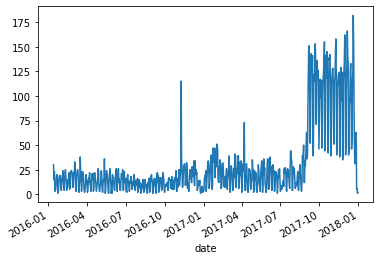

In [9]:
# number of true news spread based on date
import calendar
from pyspark.sql.functions import col,to_timestamp, to_date, when, date_format
from calendar import month_abbr

d = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'Decenmber':12 }

df_pandas = df_true.toPandas()
df_pandas['date'] = df_pandas.date.str.replace(',',"")

monthDict = {'Jan': '01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06', 
            'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}

from datetime import datetime

def check_date(x):
    correctDate = None
    try:
        correctDate=datetime.strptime(x, "%m-%d-%Y") 
    except ValueError:
        correctDate = None
    return correctDate


def convert(x):
    x[0] = x[0].capitalize()
    x[0] = x[0][0:3]
    if x[0] in monthDict.keys():
        x[0] = monthDict[x[0]]
    return x

df_pandas['date'] = df_pandas['date'].str.lower().map(lambda x: x.rstrip())
df_pandas['date'] = df_pandas['date'].str.lower().map(lambda x: x.split(' '))
df_pandas['date'] = df_pandas['date'].map(lambda x: convert(x))
df_pandas['date'] = df_pandas['date'].agg(lambda x: '-'.join(map(str, x)))
df_pandas['date'] = df_pandas['date'].map(lambda x:check_date(x))
df_pandas.groupby(df_pandas.date)['text'].count().plot(kind="line")


In [10]:
#types of news and highest number of news in order fromt he dataset
from pyspark.sql.functions import col

df.groupby('subject').count().sort(col("count").desc())

22/12/20 18:22:31 WARN TaskSetManager: Stage 5 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/20 18:22:32 WARN TaskSetManager: Stage 8 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


subject,count
politicsNews,11272
worldnews,10145
News,9050
politics,6841
left-news,4459
Government News,1570
US_News,783
Middle-east,778


22/12/20 18:22:32 WARN TaskSetManager: Stage 11 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/20 18:22:32 WARN TaskSetManager: Stage 12 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


<AxesSubplot:title={'center':'Points Scored by Team'}, ylabel='title'>

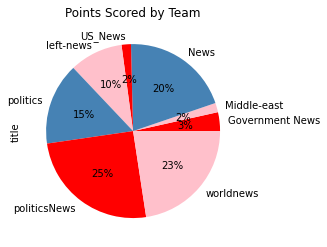

In [11]:
# Pie chart with counts of various news subjects Political and world news contained the highest counts .
from matplotlib import pyplot as plt

df1 = df

df1 = df1.toPandas()

colors = ['pink', 'silver', 'steelblue']

df1.groupby(['subject'])['title'].count().plot(kind='pie', y='count', autopct='%1.0f%%',
                                colors = ['red', 'pink', 'steelblue'],
                                title='Points Scored by Team')


In [12]:
# type of article which have fake news

df1_fake = df_fake

df1_fake.groupby(['subject']).count()

22/12/20 18:22:34 WARN TaskSetManager: Stage 15 contains a task of very large size (5255 KiB). The maximum recommended task size is 1000 KiB.
22/12/20 18:22:34 WARN TaskSetManager: Stage 18 contains a task of very large size (5255 KiB). The maximum recommended task size is 1000 KiB.


subject,count
News,9050
politics,6841
Government News,1570
left-news,4459
US_News,783
Middle-east,778


In [13]:
# type of article which have true news

df1_true = df_true

df1_true.groupby(['subject']).count()

22/12/20 18:22:34 WARN TaskSetManager: Stage 21 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.
22/12/20 18:22:34 WARN TaskSetManager: Stage 24 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


subject,count
politicsNews,11272
worldnews,10145


In [4]:
# text pre-processing

from pyspark.sql.functions import col, split, lower, regexp_replace, length

df = df.select('title',(lower(regexp_replace('text', "[^a-zA-Z\\s]", "")).alias('text')), 'subject', 'date', 'flag')

In [5]:
# tokenize the text

from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol='text', outputCol='words_token')

df = tokenizer.transform(df).select('title','words_token','subject','date','flag')

In [8]:
df.first()

22/12/21 14:38:08 WARN TaskSetManager: Stage 1 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


Row(title='Iraqi forces, Kurdish Peshmerga agree on ceasefire, Kurdistan says', words_token=['baghdad', 'reuters', '', 'iraqi', 'forces', 'and', 'kurdish', 'peshmerga', 'fighters', 'reached', 'an', 'agreement', 'on', 'friday', 'to', 'stop', 'fighting', 'in', 'northern', 'iraq', 'the', 'kurdistan', 'regional', 'government', 'krg', 'said', 'although', 'the', 'status', 'of', 'any', 'ceasefire', 'remained', 'unclear', 'a', 'spokesman', 'in', 'baghdad', 'for', 'the', 'usled', 'coalition', 'against', 'islamic', 'state', 'earlier', 'said', 'the', 'deal', 'covered', 'all', 'fronts', 'in', 'the', 'conflict', 'which', 'broke', 'out', 'after', 'kurdish', 'authorities', 'held', 'an', 'independence', 'referendum', 'last', 'month', 'in', 'areas', 'of', 'northern', 'iraq', 'however', 'he', 'later', 'told', 'reuters', 'that', 'the', 'truce', 'had', 'not', 'been', 'officially', 'agreed', 'while', 'an', 'iraqi', 'military', 'spokesman', 'declined', 'to', 'comment', 'according', 'to', 'the', 'krg', 'whic

In [6]:
#remove empty string from the frame
from pyspark.sql.functions import udf
import pyspark.sql.functions as f
from pyspark.sql.types import ArrayType

def space_removal(f):
    clean_tokens = []
    for tok in f:
        if tok:
            clean_tokens.append(tok)
    return clean_tokens

udf_space_removal = udf(space_removal, ArrayType(StringType()))

df = df.withColumn('words_token', udf_space_removal(f.col('words_token')))

In [11]:
df.first()

22/12/21 14:15:48 WARN TaskSetManager: Stage 3 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


22/12/21 14:15:50 WARN TaskSetManager: Stage 4 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


Row(title=' WATCH: Hilarious Leaked Video Shows Australian PM Mocking Trump And It’s Now The Best Thing On The Internet', words_token=['during', 'a', 'private', 'speech', 'to', 'journalists', 'australian', 'prime', 'minister', 'malcolm', 'turnbull', 'let', 'his', 'inner', 'comedian', 'shine', 'with', 'a', 'hilarious', 'impersonation', 'of', 'donald', 'trump', 'not', 'only', 'does', 'he', 'nail', 'the', 'dialogue', 'he', 'perfectly', 'executes', 'the', 'portrayal', 'down', 'to', 'donald', 's', 'awkward', 'and', 'childlike', 'arrogance', 'the', 'donald', 'and', 'i', 'we', 'are', 'winning', 'and', 'winning', 'in', 'the', 'polls', 'he', 'said', 'wednesday', 'in', 'a', 'leaked', 'video', 'we', 'are', 'winning', 'so', 'much', 'we', 'are', 'winning', 'we', 'are', 'winning', 'like', 'we', 'have', 'never', 'won', 'before', 'the', 'journalists', 'in', 'attendance', 'had', 'agreed', 'not', 'to', 'report', 'or', 'share', 'the', 'brilliant', 'mockery', 'they', 'witnessed', 'that', 'night', 'but', '

In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# remove the stop words
from pyspark.ml.feature import StopWordsRemover

stop_words_remover = StopWordsRemover(inputCol='words_token', outputCol='text').setStopWords(stop)

In [9]:
from pyspark.ml import Pipeline

stopWordRemovalPipeline = Pipeline(stages=[stop_words_remover])
pipelineFitRemoveStopWords = stopWordRemovalPipeline.fit(df)

In [10]:
df = pipelineFitRemoveStopWords.transform(df) #added here

In [15]:
df.first()

22/12/21 14:38:35 WARN TaskSetManager: Stage 2 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


22/12/21 14:38:37 WARN TaskSetManager: Stage 3 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


Row(title='Iraqi forces, Kurdish Peshmerga agree on ceasefire, Kurdistan says', words_token=['baghdad', 'reuters', 'iraqi', 'forces', 'and', 'kurdish', 'peshmerga', 'fighters', 'reached', 'an', 'agreement', 'on', 'friday', 'to', 'stop', 'fighting', 'in', 'northern', 'iraq', 'the', 'kurdistan', 'regional', 'government', 'krg', 'said', 'although', 'the', 'status', 'of', 'any', 'ceasefire', 'remained', 'unclear', 'a', 'spokesman', 'in', 'baghdad', 'for', 'the', 'usled', 'coalition', 'against', 'islamic', 'state', 'earlier', 'said', 'the', 'deal', 'covered', 'all', 'fronts', 'in', 'the', 'conflict', 'which', 'broke', 'out', 'after', 'kurdish', 'authorities', 'held', 'an', 'independence', 'referendum', 'last', 'month', 'in', 'areas', 'of', 'northern', 'iraq', 'however', 'he', 'later', 'told', 'reuters', 'that', 'the', 'truce', 'had', 'not', 'been', 'officially', 'agreed', 'while', 'an', 'iraqi', 'military', 'spokesman', 'declined', 'to', 'comment', 'according', 'to', 'the', 'krg', 'which', 

In [11]:
# most freq words in data

from pyspark.sql.functions import concat_ws

df_freq = df.withColumn("text", concat_ws(" ", df["text"]))

df_freq.show(5)

22/12/21 14:45:04 WARN TaskSetManager: Stage 0 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


22/12/21 14:45:08 WARN TaskSetManager: Stage 1 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+---------------+------------------+----+--------------------+
|               title|         words_token|        subject|              date|flag|                text|
+--------------------+--------------------+---------------+------------------+----+--------------------+
|GAY MAFIA STRIKES...|[chickfila, is, i...|Government News|      Aug 23, 2015|   0|chickfila news pu...|
|EU ready to start...|[brussels, reuter...|      worldnews| December 8, 2017 |   1|brussels reuters ...|
|Republican Rubio ...|[washington, reut...|   politicsNews| January 23, 2017 |   1|washington reuter...|
|Trump's pick Gors...|[washington, reut...|   politicsNews|   April 10, 2017 |   1|washington reuter...|
|Trump raises abou...|[washington, reut...|   politicsNews|September 7, 2016 |   1|washington reuter...|
+--------------------+--------------------+---------------+------------------+----+--------------------+
only showing top 5 rows



In [17]:
# most frequent fake words

df_fake_freq = df_freq.filter(df["flag"] == 0)

df_fake_text = df_fake_freq.select("text")


In [19]:
from pyspark.sql.functions import explode

df_fake_text = df_fake_text\
.withColumn("words", split(col("text"), " "))\
.where(length("text")>0)

df_freq_fake = df_fake_text\
.select(explode(col("words")).alias("word"))\
.groupBy("word").count()\

df_freq_fake.orderBy(col("count").desc()).show()

22/12/21 14:16:39 WARN TaskSetManager: Stage 15 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


22/12/21 14:16:57 WARN TaskSetManager: Stage 16 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


+---------+-----+
|     word|count|
+---------+-----+
|    trump|73933|
|     said|31013|
|   people|25963|
|president|25586|
|    would|23427|
|      one|22935|
|       us|22049|
|  clinton|18011|
|    obama|17813|
|     like|17621|
|   donald|17215|
|     also|15242|
|      new|14158|
|     news|14126|
|     even|13717|
|  hillary|13565|
|    white|12778|
|     time|12728|
|    state|12525|
|      via|11273|
+---------+-----+
only showing top 20 rows



In [20]:
#most true words

df_true_freq = df_freq.filter(df["flag"] == 1)

df_true_text = df_true_freq.select("text")

In [21]:
from pyspark.sql.functions import explode

df_true_text = df_true_text\
.withColumn("words", split(col("text"), " "))\
.where(length("text")>0)

df_freq_true = df_true_text\
.select(explode(col("words")).alias("word"))\
.groupBy("word").count()\

df_freq_true.orderBy(col("count").desc()).show()

22/12/21 14:17:30 WARN TaskSetManager: Stage 22 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


22/12/21 14:17:44 WARN TaskSetManager: Stage 23 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
|      word|count|
+----------+-----+
|      said|98985|
|     trump|42577|
|        us|41137|
|     would|31514|
|   reuters|28306|
| president|25533|
|     state|18753|
|government|17976|
|    states|17634|
|       new|16785|
|     house|16405|
|      also|15944|
|    united|15572|
|republican|15288|
|    people|15111|
|      told|14242|
|     could|13697|
|       one|12674|
|      last|12613|
|washington|12140|
+----------+-----+
only showing top 20 rows



In [22]:
df_freq.printSchema()

root
 |-- title: string (nullable = true)
 |-- words_token: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: integer (nullable = false)
 |-- text: string (nullable = false)



In [30]:
df_freq.count()

22/12/20 18:23:05 WARN TaskSetManager: Stage 54 contains a task of very large size (4983 KiB). The maximum recommended task size is 1000 KiB.


44898

In [12]:
# drop unwanted coloumns

df_ml = df_freq.drop("title","words_token","date")
df_ml.printSchema()

root
 |-- subject: string (nullable = true)
 |-- flag: integer (nullable = false)
 |-- text: string (nullable = false)



In [13]:
from pyspark.sql.functions import monotonically_increasing_id 

df_ml = df_ml.select("*").withColumn("id", monotonically_increasing_id())

df_ml.show()

22/12/21 14:45:55 WARN TaskSetManager: Stage 4 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


22/12/21 14:45:57 WARN TaskSetManager: Stage 5 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


+---------------+----+--------------------+---+
|        subject|flag|                text| id|
+---------------+----+--------------------+---+
|Government News|   0|chickfila news pu...|  0|
|      worldnews|   1|brussels reuters ...|  1|
|   politicsNews|   1|washington reuter...|  2|
|   politicsNews|   1|washington reuter...|  3|
|   politicsNews|   1|washington reuter...|  4|
|           News|   0|comes safety drin...|  5|
|   politicsNews|   1|washington reuter...|  6|
|           News|   0|donald trump path...|  7|
|           News|   0|sunday night abc ...|  8|
|      worldnews|   1|bangkok reuters t...|  9|
|      left-news|   0|translation sorry...| 10|
|      left-news|   0|wow women incredi...| 11|
|       politics|   0|wow talk psych ob...| 12|
|   politicsNews|   1|london reuters in...| 13|
|           News|   0|children proof ha...| 14|
|           News|   0|former texas repu...| 15|
|Government News|   0|progressive ironi...| 16|
|           News|   0|republican lawmak.

In [14]:
# x values and Y values

x = df_ml.select('text').rdd.flatMap(lambda x: x).collect()
y = df_ml.select('flag').rdd.flatMap(lambda x: x).collect()

22/12/21 14:46:03 WARN TaskSetManager: Stage 8 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


22/12/21 14:46:04 WARN TaskSetManager: Stage 9 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


22/12/21 14:46:34 WARN TaskSetManager: Stage 12 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


22/12/21 14:46:36 WARN TaskSetManager: Stage 13 contains a task of very large size (26412 KiB). The maximum recommended task size is 1000 KiB.


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.25)

In [25]:
print(x_train[0])
print(y_train[0])

madrid reuters barcelona boss ernesto valverde declined drawn friday whether declaration independence catalonia parliament meant side might end kicked la liga spanish football league president javier tebas previously quoted saying catalonia become independent region sides would able compete la liga valverde declined comment possibility happening nothing happened relation barcelona la liga talking hypothetical situations said opinion want concentrate sporting questions especially political situation appears change every half hour bid draw line spain worst political crisis years government madrid friday sacked catalonia regional government dissolved catalan parliament called snap election region dec appears doomed gesture parliament hours earlier declared independence following referendum secession spanish courts ruled illegal pitch tabletopping barca confirmed midfield playmaker andres iniesta would miss saturday visit athletic bilbao club captain week named fifpro team year thigh strai

In [17]:
#vectorize the text

from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

In [28]:
xv_train

<33673x184577 sparse matrix of type '<class 'numpy.float64'>'
	with 5448496 stored elements in Compressed Sparse Row format>

In [ ]:
xv_train.toarray()[0]

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
LR = LogisticRegression()
LR.fit(xv_train, y_train)

LogisticRegression()

In [21]:
LR.score(xv_test, y_test)

0.9879732739420936

In [33]:
pred_LR = LR.predict(xv_test)

In [34]:
classification_report(y_test, pred_LR)

'              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99      5871\n           1       0.99      0.99      0.99      5354\n\n    accuracy                           0.99     11225\n   macro avg       0.99      0.99      0.99     11225\nweighted avg       0.99      0.99      0.99     11225\n'

In [45]:
import re, string
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [47]:
import pandas as pd
def output_lable(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "Not A Fake News"
    
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wordopt) 
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    pred_LR = LR.predict(new_xv_test)

    return print("\n\nLR Prediction: {} \n".format(output_lable(pred_LR[0])))

In [48]:
news = str(input())
manual_testing(news)

  WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educa



LR Prediction: Not A Fake News 



In [ ]:
#Flagging Twitter Data

In [57]:
schema= StructType(
      [StructField('UserName',StringType(),True),
      StructField('Tweet ID',StringType(),True),
      StructField('Date',StringType(),True),
      StructField('Tweet_Text',StringType(),True)])
df = pd.read_csv('tweets.csv')
df = spark.createDataFrame(df,schema = schema)

In [58]:
df.show()

+---------------+-------------------+--------------------+--------------------+
|       UserName|           Tweet ID|                Date|          Tweet_Text|
+---------------+-------------------+--------------------+--------------------+
|robertaisbtlrdy|1605352339480649729|2022-12-20 23:59:...|RT @MariaBartirom...|
| PurpRmPolitics|1605352288507281409|2022-12-20 23:59:...|Full story https:...|
|   DailyPattaya|1605352287219732480|2022-12-20 23:59:...|The latest The Pa...|
|    basimtrades|1605352262754148352|2022-12-20 23:59:...|RT @BetterLunc: ?...|
|   hatomasu0704|1605352123222609921|2022-12-20 23:59:...|RT @NEWS_4_KMSY: ...|
|       railpage|1605352119502262273|2022-12-20 23:59:...|Boost for Wagon F...|
| thepsychicseer|1605352109163311104|2022-12-20 23:59:...|#MusicNews #News ...|
|       FaktTech|1605352103819345920|2022-12-20 23:59:...|~Elon Musk Casts ...|
|        vxmxuan|1605352078184189952|2022-12-20 23:58:...|RT @BetterLunc: ?...|
|  BigPharmaHarm|1605352035385110528|202

In [59]:
from pyspark.sql.functions import regexp_extract, split, explode
df = df.withColumn("hashtags", regexp_extract("Tweet_Text", "#\w+", 0))
df = df.withColumn("Tweet_Text", regexp_replace("Tweet_Text", "#\w+", ""))
df = df.withColumn("Tweet_Text", regexp_replace("Tweet_Text", "@\w+", ""))
df = df.withColumn("hashtags", split("hashtags", " "))
df = df.withColumn("hashtags", explode("hashtags"))
df.show()

+---------------+-------------------+--------------------+--------------------+----------------+
|       UserName|           Tweet ID|                Date|          Tweet_Text|        hashtags|
+---------------+-------------------+--------------------+--------------------+----------------+
|robertaisbtlrdy|1605352339480649729|2022-12-20 23:59:...|RT : Rep. James C...|    #foxbusiness|
| PurpRmPolitics|1605352288507281409|2022-12-20 23:59:...|Full story https:...|           #2022|
|   DailyPattaya|1605352287219732480|2022-12-20 23:59:...|The latest The Pa...|       #thailand|
|    basimtrades|1605352262754148352|2022-12-20 23:59:...|RT : 🚨BREAKING\n...|           #Lunc|
|   hatomasu0704|1605352123222609921|2022-12-20 23:59:...|RT : NEWS  |  ｢KI...|           #NEWS|
|       railpage|1605352119502262273|2022-12-20 23:59:...|Boost for Wagon F...|           #news|
| thepsychicseer|1605352109163311104|2022-12-20 23:59:...|   The Specials’ ...|      #MusicNews|
|       FaktTech|16053521038193

In [60]:
from pyspark.sql.functions import col, split, lower, regexp_replace, length

df = df.select('Tweet_Text',(lower(regexp_replace('Tweet_Text', "[^a-zA-Z\\s]", "")).alias('Text')), 'UserName', 'Date')
# df = df.withColumn("Text", regexp_replace("text", "\\s+", ""))
df = df.drop("Tweet_Text")

In [61]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol='Text', outputCol='words_token')

df = tokenizer.transform(df).select('Text','words_token','UserName','Date')
df.show()

+--------------------+--------------------+---------------+--------------------+
|                Text|         words_token|       UserName|                Date|
+--------------------+--------------------+---------------+--------------------+
|rt  rep james com...|[rt, , rep, james...|robertaisbtlrdy|2022-12-20 23:59:...|
|full story httpst...|[full, story, htt...| PurpRmPolitics|2022-12-20 23:59:...|
|the latest the pa...|[the, latest, the...|   DailyPattaya|2022-12-20 23:59:...|
|rt  breaking\n\nw...|[rt, , breaking, ...|    basimtrades|2022-12-20 23:59:...|
|rt  news    kingd...|[rt, , news, , , ...|   hatomasu0704|2022-12-20 23:59:...|
|boost for wagon f...|[boost, for, wago...|       railpage|2022-12-20 23:59:...|
|   the specials h...|[, , , the, speci...| thepsychicseer|2022-12-20 23:59:...|
|elon musk casts d...|[elon, musk, cast...|       FaktTech|2022-12-20 23:59:...|
|rt  breaking \n\n...|[rt, , breaking, ...|        vxmxuan|2022-12-20 23:58:...|
| do you think thi...|[, do,

In [62]:
from pyspark.sql.functions import udf
import pyspark.sql.functions as f
from pyspark.sql.types import ArrayType

def space_removal(f):
    clean_tokens = []
    for tok in f:
        if tok:
            clean_tokens.append(tok)
    return clean_tokens

udf_space_removal = udf(space_removal, ArrayType(StringType()))

df = df.withColumn('words_token', udf_space_removal(f.col('words_token')))

In [63]:
# remove the stop words
from pyspark.ml.feature import StopWordsRemover

stop_words_remover = StopWordsRemover(inputCol='words_token', outputCol='text').setStopWords(stop)

In [64]:
from pyspark.ml import Pipeline

stopWordRemovalPipeline = Pipeline(stages=[stop_words_remover])
pipelineFitRemoveStopWords = stopWordRemovalPipeline.fit(df)

In [65]:
df = pipelineFitRemoveStopWords.transform(df)
df.show()

+--------------------+--------------------+---------------+--------------------+
|                text|         words_token|       UserName|                Date|
+--------------------+--------------------+---------------+--------------------+
|[rt, rep, james, ...|[rt, rep, james, ...|robertaisbtlrdy|2022-12-20 23:59:...|
|[full, story, htt...|[full, story, htt...| PurpRmPolitics|2022-12-20 23:59:...|
|[latest, pattaya,...|[the, latest, the...|   DailyPattaya|2022-12-20 23:59:...|
|[rt, breaking, vo...|[rt, breaking, we...|    basimtrades|2022-12-20 23:59:...|
|[rt, news, kingdo...|[rt, news, kingdo...|   hatomasu0704|2022-12-20 23:59:...|
|[boost, wagon, fa...|[boost, for, wago...|       railpage|2022-12-20 23:59:...|
|[specials, horace...|[the, specials, h...| thepsychicseer|2022-12-20 23:59:...|
|[elon, musk, cast...|[elon, musk, cast...|       FaktTech|2022-12-20 23:59:...|
|[rt, breaking, vo...|[rt, breaking, we...|        vxmxuan|2022-12-20 23:58:...|
|[think, bought, d...|[do, y

In [66]:

from pyspark.sql.functions import concat_ws

df_freq = df.withColumn("text", concat_ws(" ", df["text"]))

df_freq.show(5)

+--------------------+--------------------+---------------+--------------------+
|                text|         words_token|       UserName|                Date|
+--------------------+--------------------+---------------+--------------------+
|rt rep james come...|[rt, rep, james, ...|robertaisbtlrdy|2022-12-20 23:59:...|
|full story httpst...|[full, story, htt...| PurpRmPolitics|2022-12-20 23:59:...|
|latest pattaya da...|[the, latest, the...|   DailyPattaya|2022-12-20 23:59:...|
|rt breaking voted...|[rt, breaking, we...|    basimtrades|2022-12-20 23:59:...|
|rt news kingdom s...|[rt, news, kingdo...|   hatomasu0704|2022-12-20 23:59:...|
+--------------------+--------------------+---------------+--------------------+
only showing top 5 rows



In [67]:
from pyspark.sql.functions import monotonically_increasing_id 

df_ml = df_freq.select("*").withColumn("id", monotonically_increasing_id())

df_ml.show()

+--------------------+--------------------+---------------+--------------------+---+
|                text|         words_token|       UserName|                Date| id|
+--------------------+--------------------+---------------+--------------------+---+
|rt rep james come...|[rt, rep, james, ...|robertaisbtlrdy|2022-12-20 23:59:...|  0|
|full story httpst...|[full, story, htt...| PurpRmPolitics|2022-12-20 23:59:...|  1|
|latest pattaya da...|[the, latest, the...|   DailyPattaya|2022-12-20 23:59:...|  2|
|rt breaking voted...|[rt, breaking, we...|    basimtrades|2022-12-20 23:59:...|  3|
|rt news kingdom s...|[rt, news, kingdo...|   hatomasu0704|2022-12-20 23:59:...|  4|
|boost wagon facil...|[boost, for, wago...|       railpage|2022-12-20 23:59:...|  5|
|specials horace p...|[the, specials, h...| thepsychicseer|2022-12-20 23:59:...|  6|
|elon musk casts d...|[elon, musk, cast...|       FaktTech|2022-12-20 23:59:...|  7|
|rt breaking voted...|[rt, breaking, we...|        vxmxuan|2022-1

In [68]:
tweets = df_ml.select('text').rdd.flatMap(lambda x: x).collect()

In [69]:
#vectorizing tweet data 
tweets_vector = vectorization.transform(tweets)


In [70]:
y_pred = LR.predict(tweets_vector)

In [71]:
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 